## IBM-Azure Trusted AI usecase
**Build & Deploy** Machine Learning model in **Azure Machine Learning Studio**

**Monitor**  the model in **IBM Watson OpenScale**

## Install Libraries

In [ ]:
!pip install ibm_cloud_sdk_core --no-cache --user | tail -n 1

In [ ]:
!pip install --upgrade ibm-watson-openscale --no-cache --user | tail -n 1

In [ ]:
!pip install ibm-cos-sdk --no-cache --user | tail -n 1
!pip install botocore==1.23.19 --no-cache --user | tail -n 1

>Action: **Restart Kernel**

## Import libraries

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

## Configure IBM Watson OpenScale and Cloud Object Storage

>**NOTE:** If you are using Watson OpenScale on IBM Cloud Pak for Data then set the `cloudWOS` variable to `False` in the below cell and uncomment `CLOUD_PAK_FOR_DATA_CREDENTIALS` variable and set the username, password and cloud pak for data url.

In [ ]:
cloudWOS = True
CLOUD_API_KEY = '***'

In [ ]:
# CLOUD_PAK_FOR_DATA_CREDENTIALS = {
#     "username" : "***", 
#     "password": "***", 
#     "url": "***" # eg https://cpd-zen.apps.efs-cluster-d05.ibmworkshops.com
# }

>**NOTE:** If you want to use any Postgres DB of your choice other than the internal Postgres to store OpenScale Metadata then comment the first line and uncomment the second line from the below cell.

In [4]:
DB_CREDENTIALS=None
#DB_CREDENTIALS= {"hostname":"","username":"","password":"","database":"","port":"","ssl":True,"sslmode":"","certificate_base64":""}

In [5]:
SCHEMA_NAME = 'azure_dm'

In [6]:
IAM_URL="https://iam.ng.bluemix.net/oidc/token"

In [7]:
COS_API_KEY_ID = "***"
COS_RESOURCE_CRN = "***" # eg "crn:v1:bluemix:public:cloud-object-storage:global:a/3bf0d9003abfb5d29761c3e97696b71c:d6f04d83-6c4f-4a62-a165-696756d63903::"
COS_ENDPOINT = "***" # Current list avaiable at https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints

In [8]:
BUCKET_NAME = "***"
training_data_file_name="german_credit_data_biased_training.csv"

## Azure Credentials are taken from the [azuremlcredentials.json](azuremlcredentials.json) file in the below cell

In [9]:
import json
with open("azuremlcredentials.json", "r") as cred:
    creds = json.load(cred)

AZURE_ENGINE_CREDENTIALS =  {
    "client_id": creds.get('appId'),
    "client_secret": creds.get('password'),
    "tenant": creds.get('tenant'),
    "subscription_id": creds.get('subscriptionid')
}

print(AZURE_ENGINE_CREDENTIALS)

## Download the Dataset

In [10]:
from IPython.utils import io

with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/credit_risk/german_credit_data_biased_training.csv -O german_credit_data_biased_training.csv
!ls -lh german_credit_data_biased_training.csv

-rwxrwxrwx 1 root root 674K Nov  7 06:50 german_credit_data_biased_training.csv


In [11]:
data = pd.read_csv('german_credit_data_biased_training.csv')
data.head()

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk


## Save training data to IBM Cloud Object Storage

In [12]:
import ibm_boto3
from ibm_botocore.client import Config, ClientError

cos_client = ibm_boto3.resource("s3",
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id=COS_RESOURCE_CRN,
    ibm_auth_endpoint=IAM_URL,
    config=Config(signature_version="oauth"),
    endpoint_url=COS_ENDPOINT
)

In [13]:
cos_client.Object(BUCKET_NAME, training_data_file_name)

s3.Object(bucket_name='openscale-manoj', key='credit_risk_training.csv')

In [14]:
with open(training_data_file_name, "rb") as file_data:
    cos_client.Object(BUCKET_NAME, training_data_file_name).upload_fileobj(
        Fileobj=file_data
    )

## Explore the data

In [15]:
print('Columns: ', list(data.columns))
print('Number of columns: ', len(data.columns))

Columns:  ['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker', 'Risk']
Number of columns:  21


In [16]:
print('Number of records: ', data.Risk.count())

Number of records:  5000


In [17]:
target_count = data.groupby('Risk')['Risk'].count()
target_count

Risk
No Risk    3330
Risk       1670
Name: Risk, dtype: int64

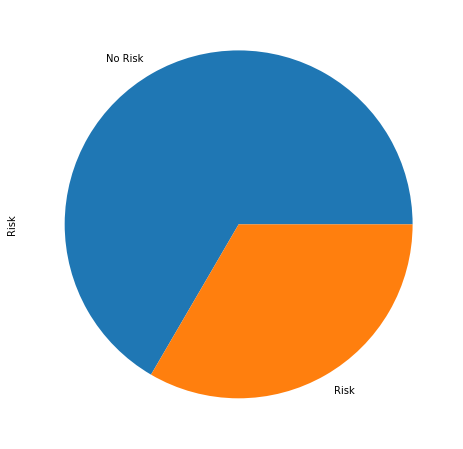

In [18]:
target_count.plot.pie(figsize=(8, 8))

## Data pre-processing

In [19]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [20]:
train_data, test_data = train_test_split(data, test_size=0.2)

In [21]:
features_idx = np.s_[0:-1]
all_records_idx = np.s_[:]
first_record_idx = np.s_[0]

In [22]:
string_fields = [type(fld) is str for fld in train_data.iloc[first_record_idx, features_idx]]
ct = ColumnTransformer([("ohe", OneHotEncoder(), list(np.array(train_data.columns)[features_idx][string_fields]))])
clf_linear = SGDClassifier(loss='log', penalty='l2', max_iter=1000, tol=1e-5)

pipeline_linear = Pipeline([('ct', ct), ('clf_linear', clf_linear)])

## Train the model

In [34]:
MODEL_NAME = "Scikit German Risk Model Azure ML"
MODEL_NAME_SHORT = 'azure_credit_risk_model'
DEPLOYMENT_NAME = "Scikit German Risk Deployment Azure ML"

In [24]:
risk_model = pipeline_linear.fit(train_data.drop('Risk', axis=1), train_data.Risk)

## Evaluate the model

In [25]:
from sklearn.metrics import roc_auc_score

predictions = risk_model.predict(test_data.drop('Risk', axis=1))
indexed_preds = [0 if prediction=='No Risk' else 1 for prediction in predictions]

real_observations = test_data.Risk.replace('Risk', 1)
real_observations = real_observations.replace('No Risk', 0).values

auc = roc_auc_score(real_observations, indexed_preds)
print(auc)

0.7436820242889305


## Store the model

In [36]:
import joblib

joblib.dump(risk_model, MODEL_NAME_SHORT+".pkl")

['azure_credit_risk_model.pkl']

## Deploy the model to Azure ML

In [27]:
import azureml.core

# Check core SDK version number.
print('SDK version:', azureml.core.VERSION)

SDK version: 1.44.0


## Initialize Azure ML workspace

In [28]:
from azureml.core import Workspace


ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

workspace_name = ws.name

data-ai
dev-manoj
eastus
7d825bce-b305-4459-ba66-cb169476f34a


## Register the model in Azure ML Service

In [37]:
import sklearn

from azureml.core import Model
from azureml.core.resource_configuration import ResourceConfiguration


model = Model.register(workspace=ws,
                       model_name=MODEL_NAME_SHORT,
                       model_path=MODEL_NAME_SHORT+'.pkl',  # Local file to upload and register as a model.
                       model_framework=Model.Framework.SCIKITLEARN,  # Framework used to create the model.
                       model_framework_version=sklearn.__version__,  # Version of scikit-learn used to create the model.
                    #    sample_input_dataset=input_dataset,
                    #    sample_output_dataset=output_dataset,
                       resource_configuration=ResourceConfiguration(cpu=1, memory_in_gb=0.5),
                       description='Random Forest Model to classify credit risk with probability vectors',
                       tags={'area': 'credit risk', 'type': 'classification'})

print('Name:', model.name)
print('Version:', model.version)

Registering model azure_credit_risk_model
Name: azure_credit_risk_model
Version: 1


## Create a custom entry script for the scoring response

In [38]:
%%writefile score_azure.py
import os
import json
import numpy as np
import pandas as pd
import joblib
from sklearn.linear_model import SGDClassifier
from azureml.core.model import Model
from sklearn import preprocessing

def init():
    global model
    model_path = Model.get_model_path('azure_credit_risk_model')
    model = joblib.load(model_path)

def run(input_payload):
    try:
        if type(input_payload) is str:
            dict_data = json.loads(input_payload)
        else:
            dict_data = input_payload

        data = pd.DataFrame.from_dict(dict_data["input"])
        predictions = model.predict(data)
        scores = model.predict_proba(data)
        risk_column = []
        proba_column = []
        proba_vector = []

        for pred, proba in zip(predictions, scores):
            risk_column.append(pred)
            proba_vector.append([proba[0], proba[1]])
            if pred == "No Risk":
                proba_column.append(proba[0])
            else:
                proba_column.append(proba[1])
        data["Scored Labels"] = risk_column
        data["Scored Probabilities"] = proba_column
        data["ProbabilityVector"] = proba_vector

        result = {"output": data.to_dict('records')}
        
        return result
    except Exception as e:
        result = str(e)
        return {"error": result}

Overwriting score_azure.py


## Create a custom environment for python

In [39]:
from azureml.core.conda_dependencies import CondaDependencies 
from azureml.core import Environment
import sklearn

environment = Environment('env-credit-risk-azure')

environment.python.conda_dependencies = CondaDependencies.create(pip_packages=[
    'azureml-defaults',
    'joblib',
    'numpy',
    'pandas',
    'scikit-learn=={}'.format(sklearn.__version__)
])

In [40]:
from azureml.core.webservice import AciWebservice


aci_config = AciWebservice.deploy_configuration(cpu_cores=0.5, memory_gb=0.5
                                                ,tags={"data": "credit_risk",  "method" : "sklearn", 'area': 'Credit Risk', 'type': 'classification'}, 
                                               description='Random Forest Model to classify credit risk.')

## Deploy the registered model as a web service

In [ ]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig
from azureml.core.image import ContainerImage


service_name = "credit-risk-model-webservice"

# Remove any existing service under the same name.
try:
    Webservice(ws, service_name).delete()
except:
    pass

inference_config = InferenceConfig(entry_script='score_azure.py', environment=environment)

service = Model.deploy(workspace=ws,
                       name=service_name,
                       models=[model],
                       inference_config=inference_config,
                       deployment_config=aci_config,
                       overwrite=True)
service.wait_for_deployment(show_output=True)

## Score the model through the web service

In [34]:
import json


input_payload = json.dumps({
    'input': train_data.drop('Risk', axis=1)[-1:].to_dict('records')
})

output = service.run(input_payload)

print(json.dumps(output, indent=2))

{
  "output": [
    {
      "CheckingStatus": "less_0",
      "LoanDuration": 4,
      "CreditHistory": "credits_paid_to_date",
      "LoanPurpose": "education",
      "LoanAmount": 604,
      "ExistingSavings": "less_100",
      "EmploymentDuration": "unemployed",
      "InstallmentPercent": 1,
      "Sex": "male",
      "OthersOnLoan": "none",
      "CurrentResidenceDuration": 1,
      "OwnsProperty": "savings_insurance",
      "Age": 29,
      "InstallmentPlans": "stores",
      "Housing": "rent",
      "ExistingCreditsCount": 1,
      "Job": "unskilled",
      "Dependents": 1,
      "Telephone": "none",
      "ForeignWorker": "yes",
      "Scored Labels": "No Risk",
      "Scored Probabilities": 0.9680070361361682,
      "ProbabilityVector": [
        0.9680070361361682,
        0.03199296386383178
      ]
    }
  ]
}


>--------------------------

## At this point in the Notebook, You have successfully Build and Deployed the model in Azure Machine Learning. Now you can proceed to configure the IBM Watson OpenScale monitors.

>--------------------------

## Configure OpenScale

In [30]:
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator,CloudPakForDataAuthenticator

from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *

if cloudWOS:
    authenticator = IAMAuthenticator(
        apikey=CLOUD_API_KEY
    )
    wos_client = APIClient(authenticator=authenticator)
    print('Watson OpenScale on IBM Cloud!')
else:
    authenticator = CloudPakForDataAuthenticator(
        username=CLOUD_PAK_FOR_DATA_CREDENTIALS.get('username'), 
        password=CLOUD_PAK_FOR_DATA_CREDENTIALS.get('password'), 
        url=CLOUD_PAK_FOR_DATA_CREDENTIALS.get('url'), 
        disable_ssl_verification=True
    )
    wos_client = APIClient(
        service_url=CLOUD_PAK_FOR_DATA_CREDENTIALS.get('url'),
        authenticator=authenticator
    )
    print('Watson OpenScale on IBM Cloud pak for Data!')

wos_client.version

'3.0.23'

### DataMart setup
Watson OpenScale uses a database to store payload logs and calculated metrics. If database credentials were **not** supplied above, the notebook will use the free, internal lite database. If database credentials were supplied, the datamart will be created there **unless** there is an existing datamart **and** the **KEEP_MY_INTERNAL_POSTGRES** variable is set to **True**. If an OpenScale datamart exists in Db2 or PostgreSQL, the existing datamart will be used and no data will be overwritten.

Prior instances of the German Credit model will be removed from OpenScale monitoring.

In [31]:
wos_client.data_marts.show()

AIOSFASTPATHICP-00000000-0000-0000-0000-000000000000,Data Mart created by OpenScale ExpressPath,False,active,2022-10-06 06:00:45.524000+00:00,00000000-0000-0000-0000-000000000000


In [32]:
data_marts = wos_client.data_marts.list().result.data_marts
if len(data_marts) == 0:
    if DB_CREDENTIALS is not None:
        if SCHEMA_NAME is None: 
            print("Please specify the SCHEMA_NAME and rerun the cell")

        print('Setting up external datamart')
        added_data_mart_result = wos_client.data_marts.add(
                background_mode=False,
                name="WOS Data Mart",
                description="Data Mart created by WOS tutorial notebook",
                database_configuration=DatabaseConfigurationRequest(
                  database_type=DatabaseType.POSTGRESQL,
                    credentials=PrimaryStorageCredentialsLong(
                        hostname=DB_CREDENTIALS['hostname'],
                        username=DB_CREDENTIALS['username'],
                        password=DB_CREDENTIALS['password'],
                        db=DB_CREDENTIALS['database'],
                        port=DB_CREDENTIALS['port'],
                        ssl=True,
                        sslmode=DB_CREDENTIALS['sslmode'],
                        certificate_base64=DB_CREDENTIALS['certificate_base64']
                    ),
                    location=LocationSchemaName(
                        schema_name= SCHEMA_NAME
                    )
                )
             ).result
    else:
        print('Setting up internal datamart')
        added_data_mart_result = wos_client.data_marts.add(
                background_mode=False,
                name="WOS Data Mart",
                description="Data Mart created by WOS tutorial notebook", 
                internal_database = True).result
        
    data_mart_id = added_data_mart_result.metadata.id
    
else:
    data_mart_id=data_marts[0].metadata.id
    print('Using existing datamart {}'.format(data_mart_id))

Using existing datamart 00000000-0000-0000-0000-000000000000


In [33]:
SERVICE_PROVIDER_NAME = "Azure Machine Learning Service"
SERVICE_PROVIDER_DESCRIPTION = "Added by Azure Machine Learning Studio notebook."

## Remove existing service provider connected with used  Azure ML instance
Multiple service providers for the same engine instance are avaiable in Watson OpenScale. To avoid multiple service providers of used WML instance in the tutorial notebook the following code deletes existing service provder(s) and then adds new one. 

In [34]:
service_providers = wos_client.service_providers.list().result.service_providers
for service_provider in service_providers:
    service_instance_name = service_provider.entity.name
    if service_instance_name == SERVICE_PROVIDER_NAME:
        service_provider_id = service_provider.metadata.id
        wos_client.service_providers.delete(service_provider_id)
        print("Deleted existing service_provider for Azure ML instance: {}".format(service_provider_id))

Deleted existing service_provider for Azure ML instance: e152a1fd-4ffe-4d18-afa8-c8fe8c3bc990


In [35]:
wos_client.service_providers.show()

None,active,AWS SGM Machine Learning,amazon_sagemaker,2022-10-10 08:15:48.365000+00:00,6823dbe2-a5f8-4382-b962-9ea4b4686d32
99999999-9999-9999-9999-999999999999,active,WOS ExpressPath WML pre_production binding,watson_machine_learning,2022-10-06 06:01:06.777000+00:00,e5b7a117-41d5-406e-ac25-5d7df0ae63b8
99999999-9999-9999-9999-999999999999,active,WOS ExpressPath WML production binding,watson_machine_learning,2022-10-06 06:01:01.449000+00:00,fcf1fa79-0a2f-4c6f-8813-8c6f0c3f954b


## Add service provider (Azure Machine Learning Service)
Watson OpenScale needs to be bound to the Azure Machine Learning Service to capture payload data into and out of the model.

In [36]:
added_service_provider_result = wos_client.service_providers.add(
        name=SERVICE_PROVIDER_NAME,
        description=SERVICE_PROVIDER_DESCRIPTION,
        service_type=ServiceTypes.AZURE_MACHINE_LEARNING_SERVICE,
        credentials=AzureCredentials(
            subscription_id= AZURE_ENGINE_CREDENTIALS['subscription_id'], 
            client_id = AZURE_ENGINE_CREDENTIALS['client_id'], 
            client_secret= AZURE_ENGINE_CREDENTIALS['client_secret'],
            tenant = AZURE_ENGINE_CREDENTIALS['tenant']
        ),
        background_mode=False
    ).result
service_provider_id = added_service_provider_result.metadata.id




 Waiting for end of adding service provider 3f79e275-7f02-4559-bf4c-db664b4e08d9 




active

-----------------------------------------------
 Successfully finished adding service provider 
-----------------------------------------------




In [37]:
wos_client.service_providers.show()

None,active,Azure Machine Learning Service,azure_machine_learning_service,2022-10-12 19:30:43.884000+00:00,3f79e275-7f02-4559-bf4c-db664b4e08d9
None,active,AWS SGM Machine Learning,amazon_sagemaker,2022-10-10 08:15:48.365000+00:00,6823dbe2-a5f8-4382-b962-9ea4b4686d32
99999999-9999-9999-9999-999999999999,active,WOS ExpressPath WML pre_production binding,watson_machine_learning,2022-10-06 06:01:06.777000+00:00,e5b7a117-41d5-406e-ac25-5d7df0ae63b8
99999999-9999-9999-9999-999999999999,active,WOS ExpressPath WML production binding,watson_machine_learning,2022-10-06 06:01:01.449000+00:00,fcf1fa79-0a2f-4c6f-8813-8c6f0c3f954b


## View all the models deployed in Azure ML

In [38]:
asset_deployment_details = wos_client.service_providers.list_assets(data_mart_id=data_mart_id, service_provider_id=service_provider_id).result
asset_deployment_details

{'resources': [{'metadata': {'guid': '678b5e4bd49125eb6f446c72bdad0661',
    'url': 'https://eastus.modelmanagement.azureml.net/api/subscriptions/7d825bce-b305-4459-ba66-cb169476f34a/resourceGroups/dev-manoj/providers/Microsoft.MachineLearningServices/workspaces/data-ai/services/credit-risk-model-azure?api-version=2018-03-01-preview',
    'created_at': '2022-10-12T15:09:40.9721851Z',
    'modified_at': '2022-10-12T15:09:40.9721851Z'},
   'entity': {'name': 'credit-risk-model-azure',
    'deployment_rn': 'credit-risk-model-azure',
    'type': 'online',
    'description': 'Random Forest Model to classify credit risk.',
    'scoring_endpoint': {'url': 'http://c1e2f300-cc84-4d6b-9989-40aa1a0c9c90.eastus.azurecontainer.io/score',
     'request_headers': {'Content-Type': 'application/json; charset=UTF-8'}},
    'asset': {'asset_id': 'c7c1229c8e4d0b49b8bbdebb01fdbbba',
     'asset_rn': 'credit-risk-model-azure',
     'url': 'https://eastus.modelmanagement.azureml.net/api/subscriptions/7d825bc

## Score the model

In [39]:
## select your model deployment GUID and get model asset details
deployment_id='678b5e4bd49125eb6f446c72bdad0661'
for model_asset_details in asset_deployment_details['resources']:
    if model_asset_details['metadata']['guid']==deployment_id:
        break

In [40]:
import requests
import time
import json

scoring_url = model_asset_details['entity']['scoring_endpoint']['url']

data = {
  "input": [
    {
      "CheckingStatus": "less_0",
      "LoanDuration": 8,
      "CreditHistory": "prior_payments_delayed",
      "LoanPurpose": "car_new",
      "LoanAmount": 368,
      "ExistingSavings": "less_100",
      "EmploymentDuration": "less_1",
      "InstallmentPercent": 2,
      "Sex": "female",
      "OthersOnLoan": "none",
      "CurrentResidenceDuration": 2,
      "OwnsProperty": "real_estate",
      "Age": 29,
      "InstallmentPlans": "none",
      "Housing": "rent",
      "ExistingCreditsCount": 1,
      "Job": "skilled",
      "Dependents": 1,
      "Telephone": "none",
      "ForeignWorker": "yes"
    }
  ]
}

body = str.encode(json.dumps(data))

headers = model_asset_details['entity']['scoring_endpoint']['request_headers']

start_time = time.time()
response = requests.post(url=scoring_url, data=body, headers=headers)
response_time = int(time.time() - start_time)*1000
result = response.json()

print("Scoring URL: {}".format(scoring_url))
print(json.dumps(result, indent=2))

Scoring URL: http://c1e2f300-cc84-4d6b-9989-40aa1a0c9c90.eastus.azurecontainer.io/score
{
  "output": [
    {
      "CheckingStatus": "less_0",
      "LoanDuration": 8,
      "CreditHistory": "prior_payments_delayed",
      "LoanPurpose": "car_new",
      "LoanAmount": 368,
      "ExistingSavings": "less_100",
      "EmploymentDuration": "less_1",
      "InstallmentPercent": 2,
      "Sex": "female",
      "OthersOnLoan": "none",
      "CurrentResidenceDuration": 2,
      "OwnsProperty": "real_estate",
      "Age": 29,
      "InstallmentPlans": "none",
      "Housing": "rent",
      "ExistingCreditsCount": 1,
      "Job": "skilled",
      "Dependents": 1,
      "Telephone": "none",
      "ForeignWorker": "yes",
      "Scored Labels": "No Risk",
      "Scored Probabilities": 0.964201761018031,
      "ProbabilityVector": [
        0.964201761018031,
        0.03579823898196898
      ]
    }
  ]
}


## Subscribe to the Azure ML model

In [41]:
wos_client.subscriptions.show()

31a9027642aab462e18bfb537e438f0b,linear-learner-2022-10-10-12-00-13-476,00000000-0000-0000-0000-000000000000,31a9027642aab462e18bfb537e438f0b,linear-learner-2022-10-10-12-00-13-476,6823dbe2-a5f8-4382-b962-9ea4b4686d32,active,2022-10-10 12:08:37.765000+00:00,deb38751-958a-487a-b473-37c027d41796
992430a009a4cf1c3c0a412583bd102b,linear-learner-2022-10-07-12-34-39-079,00000000-0000-0000-0000-000000000000,992430a009a4cf1c3c0a412583bd102b,linear-learner-2022-10-07-12-34-39-079,6823dbe2-a5f8-4382-b962-9ea4b4686d32,active,2022-10-10 08:15:54.133000+00:00,ca600f59-ba9b-47c1-a2b8-6aab6bcdc2a1


## Define input and output schemas

In [42]:
feature_columns = ['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker']
categorical_columns = ['CheckingStatus', 'CreditHistory', 'LoanPurpose', 'ExistingSavings', 'EmploymentDuration', 'Sex', 'OthersOnLoan', 'OwnsProperty', 'InstallmentPlans', 'Housing', 'Job', 'Telephone', 'ForeignWorker']

In [43]:
training_schema = {
    "type": "struct",
    "fields": [
        {
            "name": "CheckingStatus",
            "type": "string",
            "nullable": False
        },
        {
            "name": "LoanDuration",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "CreditHistory",
            "type": "string",
            "nullable": False
        },
        {
            "name": "LoanPurpose",
            "type": "string",
            "nullable": False
        },
        {
            "name": "LoanAmount",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "ExistingSavings",
            "type": "string",
            "nullable": False
        },
        {
            "name": "EmploymentDuration",
            "type": "string",
            "nullable": False
        },
        {
            "name": "InstallmentPercent",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "Sex",
            "type": "string",
            "nullable": False
        },
        {
            "name": "OthersOnLoan",
            "type": "string",
            "nullable": False
        },
        {
            "name": "CurrentResidenceDuration",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "OwnsProperty",
            "type": "string",
            "nullable": False
        },
        {
            "name": "Age",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "InstallmentPlans",
            "type": "string",
            "nullable": False
        },
        {
            "name": "Housing",
            "type": "string",
            "nullable": False
        },
        {
            "name": "ExistingCreditsCount",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "Job",
            "type": "string",
            "nullable": False
        },
        {
            "name": "Dependents",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "Telephone",
            "type": "string",
            "nullable": False
        },
        {
            "name": "ForeignWorker",
            "type": "string",
            "nullable": False
        },
        {
            "name": "Risk",
            "type": "string",
            "nullable": False,
            "metadata": {
                "modeling_role": "target"
            }
        }
    ]
}

In [44]:
input_schema = {
    "type": "struct",
    "fields": [
        {
            "name": "CheckingStatus",
            "type": "string",
            "nullable": False
        },
        {
            "name": "LoanDuration",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "CreditHistory",
            "type": "string",
            "nullable": False
        },
        {
            "name": "LoanPurpose",
            "type": "string",
            "nullable": False
        },
        {
            "name": "LoanAmount",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "ExistingSavings",
            "type": "string",
            "nullable": False
        },
        {
            "name": "EmploymentDuration",
            "type": "string",
            "nullable": False
        },
        {
            "name": "InstallmentPercent",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "Sex",
            "type": "string",
            "nullable": False
        },
        {
            "name": "OthersOnLoan",
            "type": "string",
            "nullable": False
        },
        {
            "name": "CurrentResidenceDuration",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "OwnsProperty",
            "type": "string",
            "nullable": False
        },
        {
            "name": "Age",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "InstallmentPlans",
            "type": "string",
            "nullable": False
        },
        {
            "name": "Housing",
            "type": "string",
            "nullable": False
        },
        {
            "name": "ExistingCreditsCount",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "Job",
            "type": "string",
            "nullable": False
        },
        {
            "name": "Dependents",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "Telephone",
            "type": "string",
            "nullable": False
        },
        {
            "name": "ForeignWorker",
            "type": "string",
            "nullable": False
        }
    ]
}

In [45]:
output_schema = {
    "type": "struct",
    "fields": [
        {
            "name": "CheckingStatus",
            "type": "string",
            "nullable": False
        },
        {
            "name": "LoanDuration",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "CreditHistory",
            "type": "string",
            "nullable": False
        },
        {
            "name": "LoanPurpose",
            "type": "string",
            "nullable": False
        },
        {
            "name": "LoanAmount",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "ExistingSavings",
            "type": "string",
            "nullable": False
        },
        {
            "name": "EmploymentDuration",
            "type": "string",
            "nullable": False
        },
        {
            "name": "InstallmentPercent",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "Sex",
            "type": "string",
            "nullable": False
        },
        {
            "name": "OthersOnLoan",
            "type": "string",
            "nullable": False
        },
        {
            "name": "CurrentResidenceDuration",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "OwnsProperty",
            "type": "string",
            "nullable": False
        },
        {
            "name": "Age",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "InstallmentPlans",
            "type": "string",
            "nullable": False
        },
        {
            "name": "Housing",
            "type": "string",
            "nullable": False
        },
        {
            "name": "ExistingCreditsCount",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "Job",
            "type": "string",
            "nullable": False
        },
        {
            "name": "Dependents",
            "type": "integer",
            "nullable": False
        },
        {
            "name": "Telephone",
            "type": "string",
            "nullable": False
        },
        {
            "name": "ForeignWorker",
            "type": "string",
            "nullable": False
        },
        {
            "name": "Scored Labels",
            "type": "string",
            "nullable": False,
            "metadata": {
                "modeling_role": "prediction"
            }
        },
        {
            "name": "Scored Probabilities",
            "type": "double",
            "nullable": False,
            "metadata": {
                "modeling_role": "class_probability"
            }
        },
        {
            "name": "ProbabilityVector",
            "type": {
                "type": "array",
                "elementType": "double",
                "containsNull": False
            },
            "nullable": False,
            "metadata": {
                "modeling_role": "probability"
            }
        }
    ]
}

## Add Subscription

In [46]:
from ibm_watson_openscale.base_classes.watson_open_scale_v2 import ScoringEndpointRequest

In [47]:
subscription_details = wos_client.subscriptions.add(
        background_mode=False,
        data_mart_id=data_mart_id,
        service_provider_id=service_provider_id,
        asset=Asset(
            asset_id=model_asset_details["entity"]["asset"]["asset_id"],
            name=model_asset_details["entity"]["asset"]["name"],
            url=model_asset_details["entity"]["asset"]["url"],
            asset_type=AssetTypes.MODEL,
            input_data_type=InputDataType.STRUCTURED,
            problem_type=ProblemType.BINARY_CLASSIFICATION
        ),
        deployment=AssetDeploymentRequest(
            deployment_id=model_asset_details['metadata']['guid'],
            name=model_asset_details['entity']['name'],
            deployment_type= DeploymentTypes.ONLINE,
            url=model_asset_details['metadata']['url'],
            scoring_endpoint=ScoringEndpointRequest(url = model_asset_details['entity']['scoring_endpoint']["url"])
        ),
        asset_properties=AssetPropertiesRequest(
            label_column = 'Risk',
            prediction_field = 'Scored Labels',
            probability_fields = ['Scored Probabilities'],
            feature_fields = feature_columns,
            categorical_fields = categorical_columns,
            training_data_reference = TrainingDataReference(type = 'cos',
                                                          location = COSTrainingDataReferenceLocation(bucket = BUCKET_NAME,
                                                                                                    file_name = training_data_file_name),
                                                          connection = COSTrainingDataReferenceConnection.from_dict({
                                                                        "resource_instance_id": COS_RESOURCE_CRN,
                                                                        "url": COS_ENDPOINT,
                                                                        "api_key": COS_API_KEY_ID,
                                                                        "iam_url": IAM_URL})),
            training_data_schema = SparkStruct.from_dict(training_schema),
            input_data_schema = SparkStruct.from_dict(input_schema),
            output_data_schema = SparkStruct.from_dict(output_schema)
        )
    ).result
subscription_id = subscription_details.metadata.id
subscription_id




 Waiting for end of adding subscription bcb5d10c-644e-46ca-8701-2dea3414982e 




preparing
active

-------------------------------------------
 Successfully finished adding subscription 
-------------------------------------------




'bcb5d10c-644e-46ca-8701-2dea3414982e'

## Payload Logging

In [48]:
import time

time.sleep(5)
payload_data_set_id = None
payload_data_set_id = wos_client.data_sets.list(type=DataSetTypes.PAYLOAD_LOGGING, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
if payload_data_set_id is None:
    print("Payload data set not found. Please check subscription status.")
else:
    print("Payload data set id: ", payload_data_set_id)

Payload data set id:  4535e86f-b44e-4251-80a1-2822da6af8bd


In [49]:
import requests
import time
import json

subscription_details=wos_client.subscriptions.get(subscription_id).result.to_dict()
scoring_url = subscription_details['entity']['deployment']['scoring_endpoint']['url']

data = {
    "input": train_data.sample(3).drop(['Risk'],axis=1).to_dict('records')
    }

body = str.encode(json.dumps(data))

headers = model_asset_details['entity']['scoring_endpoint']['request_headers']

start_time = time.time()
response = requests.post(url=scoring_url, data=body, headers=headers)
response_time = int(time.time() - start_time)*1000
result = response.json()

print(json.dumps(result, indent=2))

{
  "output": [
    {
      "CheckingStatus": "no_checking",
      "LoanDuration": 32,
      "CreditHistory": "prior_payments_delayed",
      "LoanPurpose": "education",
      "LoanAmount": 6332,
      "ExistingSavings": "100_to_500",
      "EmploymentDuration": "4_to_7",
      "InstallmentPercent": 5,
      "Sex": "female",
      "OthersOnLoan": "none",
      "CurrentResidenceDuration": 5,
      "OwnsProperty": "savings_insurance",
      "Age": 50,
      "InstallmentPlans": "none",
      "Housing": "own",
      "ExistingCreditsCount": 2,
      "Job": "management_self-employed",
      "Dependents": 2,
      "Telephone": "yes",
      "ForeignWorker": "yes",
      "Scored Labels": "Risk",
      "Scored Probabilities": 0.6604160487788415,
      "ProbabilityVector": [
        0.3395839512211585,
        0.6604160487788415
      ]
    },
    {
      "CheckingStatus": "no_checking",
      "LoanDuration": 34,
      "CreditHistory": "prior_payments_delayed",
      "LoanPurpose": "furniture",
 

## Convert payload data format for OpenScale 

In [50]:
def convert_user_input_2_openscale(input_data):
    users_records = input_data['input']
    openscale_fields = list(users_records[0])
    openscale_values = [[rec[k] for k in openscale_fields] for rec in users_records] 

    return {'fields':openscale_fields, 'values':openscale_values}

In [51]:
import numpy as np
def convert_user_output_2_openscale(output_data):
    users_records = output_data['output']
    openscale_fields = ["Scored Labels","Scored Probabilities"]
    openscale_values = [[np.double(rec[k]) if k=='Scored Probabilities' else rec[k] for k in openscale_fields ] for rec in users_records] 

    return {'fields':openscale_fields, 'values':openscale_values}

In [52]:
openscale_input=convert_user_input_2_openscale(data)
openscale_output=convert_user_output_2_openscale(result)

## Store the request and response in payload logging table

In [53]:
import uuid
from ibm_watson_openscale.supporting_classes.payload_record import PayloadRecord

print("Performing explicit payload logging.....")
wos_client.data_sets.store_records(data_set_id=payload_data_set_id, request_body=[PayloadRecord(
           scoring_id=str(uuid.uuid4()),
           request=openscale_input,
           response=openscale_output,
           response_time=460
)])
time.sleep(5)
pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
print("Number of records in the payload logging table: {}".format(pl_records_count))

Performing explicit payload logging.....
Number of records in the payload logging table: 3


In [54]:
wos_client.data_sets.show_records(data_set_id=payload_data_set_id)

None,6332,1c85bbe3-9988-4342-b295-78321a30b149-1,5,100_to_500,2022-10-12T19:31:46.437Z,0.6604160487788415,"[0.6604160487788415, 0.3395839512211585]",no_checking,education,0.6604160487788415,management_self-employed,none,none,32,50,prior_payments_delayed,5,yes,own,2,678b5e4bd49125eb6f446c72bdad0661,yes,Risk,female,2,savings_insurance,4_to_7
None,4842,1c85bbe3-9988-4342-b295-78321a30b149-2,4,unknown,2022-10-12T19:31:46.437Z,0.7091848324047734,"[0.7091848324047734, 0.2908151675952266]",no_checking,furniture,0.7091848324047734,skilled,none,none,34,49,prior_payments_delayed,3,yes,own,3,678b5e4bd49125eb6f446c72bdad0661,yes,Risk,male,2,unknown,4_to_7
None,3714,1c85bbe3-9988-4342-b295-78321a30b149-3,4,500_to_1000,2022-10-12T19:31:46.437Z,0.7120891179524814,"[0.7120891179524814, 0.2879108820475186]",no_checking,radio_tv,0.7120891179524814,unemployed,bank,none,35,41,prior_payments_delayed,4,yes,own,2,678b5e4bd49125eb6f446c72bdad0661,yes,Risk,female,1,unknown,4_to_7


## Feedback logging & quality (accuracy) monitoring

## Enable Quality Monitoring

In [55]:
import time

time.sleep(10)
target = Target(
        target_type=TargetTypes.SUBSCRIPTION,
        target_id=subscription_id
)
parameters = {
    "min_feedback_data_size": 10
}
thresholds = [
                {
                    "metric_id": "area_under_roc",
                    "type": "lower_limit",
                    "value": .80
                }
            ]
quality_monitor_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.QUALITY.ID,
    target=target,
    parameters=parameters,
    thresholds=thresholds
).result
quality_monitor_instance_id = quality_monitor_details.metadata.id
quality_monitor_instance_id




 Waiting for end of monitor instance creation dbaa2dff-9c95-4a79-bfc0-08c29fdd67d0 




active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




'dbaa2dff-9c95-4a79-bfc0-08c29fdd67d0'

## Feedback records logging

In [56]:
!rm additional_feedback_data_v2.json
!wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/credit_risk/additional_feedback_data_v2.json

--2022-10-12 19:32:10--  https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/credit_risk/additional_feedback_data_v2.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50890 (50K) [text/plain]
Saving to: ‘additional_feedback_data_v2.json’

additional_feedback 100%[===================>]  49.70K  --.-KB/s    in 0.01s   

2022-10-12 19:32:10 (3.90 MB/s) - ‘additional_feedback_data_v2.json’ saved [50890/50890]



In [57]:
feedback_dataset_id = None
feedback_dataset = wos_client.data_sets.list(type=DataSetTypes.FEEDBACK, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result
#print(feedback_dataset)
feedback_dataset_id = feedback_dataset.data_sets[0].metadata.id
if feedback_dataset_id is None:
    print("Feedback data set not found. Please check quality monitor status.")

In [58]:
with open('additional_feedback_data_v2.json') as feedback_file:
    additional_feedback_data = json.load(feedback_file)
wos_client.data_sets.store_records(feedback_dataset_id, request_body=additional_feedback_data, background_mode=False)




 Waiting for end of storing records with request id: c0e0a3e5-500d-47c3-822e-080112a27263 




active

---------------------------------------
 Successfully finished storing records 
---------------------------------------




In [59]:
wos_client.data_sets.get_records_count(data_set_id=feedback_dataset_id)

98

In [60]:
run_details = wos_client.monitor_instances.run(monitor_instance_id=quality_monitor_instance_id, background_mode=False).result




 Waiting for end of monitoring run 84ced599-4715-42f6-9916-20ac4cce334a 




running
finished

---------------------------
 Successfully finished run 
---------------------------




In [61]:
time.sleep(5)
wos_client.monitor_instances.show_metrics(monitor_instance_id=quality_monitor_instance_id)

2022-10-12 19:32:17.376000+00:00,true_positive_rate,dbe0b84f-882f-4a33-be48-142b05d8904a,0.48484848484848486,None,None,['model_type:original'],quality,dbaa2dff-9c95-4a79-bfc0-08c29fdd67d0,84ced599-4715-42f6-9916-20ac4cce334a,subscription,bcb5d10c-644e-46ca-8701-2dea3414982e
2022-10-12 19:32:17.376000+00:00,area_under_roc,dbe0b84f-882f-4a33-be48-142b05d8904a,0.703962703962704,0.8,None,['model_type:original'],quality,dbaa2dff-9c95-4a79-bfc0-08c29fdd67d0,84ced599-4715-42f6-9916-20ac4cce334a,subscription,bcb5d10c-644e-46ca-8701-2dea3414982e
2022-10-12 19:32:17.376000+00:00,precision,dbe0b84f-882f-4a33-be48-142b05d8904a,0.7619047619047619,None,None,['model_type:original'],quality,dbaa2dff-9c95-4a79-bfc0-08c29fdd67d0,84ced599-4715-42f6-9916-20ac4cce334a,subscription,bcb5d10c-644e-46ca-8701-2dea3414982e
2022-10-12 19:32:17.376000+00:00,f1_measure,dbe0b84f-882f-4a33-be48-142b05d8904a,0.5925925925925926,None,None,['model_type:original'],quality,dbaa2dff-9c95-4a79-bfc0-08c29fdd67d0,84ced599-4715-42f6-9916-20ac4cce334a,subscription,bcb5d10c-644e-46ca-8701-2dea3414982e
2022-10-12 19:32:17.376000+00:00,accuracy,dbe0b84f-882f-4a33-be48-142b05d8904a,0.7755102040816326,None,None,['model_type:original'],quality,dbaa2dff-9c95-4a79-bfc0-08c29fdd67d0,84ced599-4715-42f6-9916-20ac4cce334a,subscription,bcb5d10c-644e-46ca-8701-2dea3414982e
2022-10-12 19:32:17.376000+00:00,log_loss,dbe0b84f-882f-4a33-be48-142b05d8904a,0.43134754941884784,None,None,['model_type:original'],quality,dbaa2dff-9c95-4a79-bfc0-08c29fdd67d0,84ced599-4715-42f6-9916-20ac4cce334a,subscription,bcb5d10c-644e-46ca-8701-2dea3414982e
2022-10-12 19:32:17.376000+00:00,false_positive_rate,dbe0b84f-882f-4a33-be48-142b05d8904a,0.07692307692307693,None,None,['model_type:original'],quality,dbaa2dff-9c95-4a79-bfc0-08c29fdd67d0,84ced599-4715-42f6-9916-20ac4cce334a,subscription,bcb5d10c-644e-46ca-8701-2dea3414982e
2022-10-12 19:32:17.376000+00:00,area_under_pr,dbe0b84f-882f-4a33-be48-142b05d8904a,0.6523912595341167,None,None,['model_type:original'],quality,dbaa2dff-9c95-4a79-bfc0-08c29fdd67d0,84ced599-4715-42f6-9916-20ac4cce334a,subscription,bcb5d10c-644e-46ca-8701-2dea3414982e
2022-10-12 19:32:17.376000+00:00,recall,dbe0b84f-882f-4a33-be48-142b05d8904a,0.48484848484848486,None,None,['model_type:original'],quality,dbaa2dff-9c95-4a79-bfc0-08c29fdd67d0,84ced599-4715-42f6-9916-20ac4cce334a,subscription,bcb5d10c-644e-46ca-8701-2dea3414982e


## Fairness, Drift monitoring and explanations

In [62]:
wos_client.monitor_instances.show()

00000000-0000-0000-0000-000000000000,active,bcb5d10c-644e-46ca-8701-2dea3414982e,subscription,quality,2022-10-12 19:32:05.212000+00:00,dbaa2dff-9c95-4a79-bfc0-08c29fdd67d0
00000000-0000-0000-0000-000000000000,active,ca600f59-ba9b-47c1-a2b8-6aab6bcdc2a1,subscription,fairness,2022-10-10 08:17:18.613000+00:00,4929b2f9-6cc3-45b5-924b-9258a8438e5f
00000000-0000-0000-0000-000000000000,active,ca600f59-ba9b-47c1-a2b8-6aab6bcdc2a1,subscription,drift,2022-10-10 11:22:10.956000+00:00,9711c84c-0084-4073-a2e1-a45c1fd4de5a
00000000-0000-0000-0000-000000000000,active,dff28f4a-6a58-483c-bd17-583c3e9ddec9,instance,performance,2022-10-12 12:06:21.282000+00:00,b733e84f-8e9f-4d8e-a26d-564cfd52865c
00000000-0000-0000-0000-000000000000,active,deb38751-958a-487a-b473-37c027d41796,subscription,mrm,2022-10-10 12:08:47.171000+00:00,e70a055d-2d92-468c-a0de-d5a8104479d7
00000000-0000-0000-0000-000000000000,active,deb38751-958a-487a-b473-37c027d41796,subscription,performance,2022-10-10 12:08:47.402000+00:00,9699f5d0-3268-4658-9efc-5c04f4c09665
00000000-0000-0000-0000-000000000000,active,ca600f59-ba9b-47c1-a2b8-6aab6bcdc2a1,subscription,mrm,2022-10-10 08:20:12.909000+00:00,4a5dc691-e780-4baf-94c7-efdfaf462906
00000000-0000-0000-0000-000000000000,error,ca600f59-ba9b-47c1-a2b8-6aab6bcdc2a1,subscription,explainability,2022-10-10 08:17:44.323000+00:00,2a877386-ecdf-44dc-b344-032dcec11930
00000000-0000-0000-0000-000000000000,active,ca600f59-ba9b-47c1-a2b8-6aab6bcdc2a1,subscription,quality,2022-10-10 08:16:33.027000+00:00,ae6c887b-142c-4e02-8359-b55f8425f613


In [63]:
target = Target(
    target_type=TargetTypes.SUBSCRIPTION,
    target_id=subscription_id

)
parameters = {
    "features": [
        {"feature": "Sex",
         "majority": ['male'],
         "minority": ['female'],
         "threshold": 0.80
         },
        {"feature": "Age",
         "majority": [[26, 75]],
         "minority": [[18, 25]],
         "threshold": 0.80
         }
    ],
    "favourable_class": ["No Risk"],
    "unfavourable_class": ["Risk"],
    "min_records": 40
}

fairness_monitor_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.FAIRNESS.ID,
    target=target,
    parameters=parameters).result
fairness_monitor_instance_id =fairness_monitor_details.metadata.id
fairness_monitor_instance_id




 Waiting for end of monitor instance creation eeca6120-7fce-4173-904c-77ca5c7f7c83 




active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




'eeca6120-7fce-4173-904c-77ca5c7f7c83'

## Store the request and response in payload logging table

In [91]:
import requests
import time
import json

scoring_url = subscription_details['entity']['deployment']['scoring_endpoint']['url']

payload_data = {
    "input": train_data.sample(180).drop(['Risk'],axis=1).to_dict('records')
    }

pl_body = str.encode(json.dumps(payload_data))

headers = model_asset_details['entity']['scoring_endpoint']['request_headers']

start_time = time.time()
response = requests.post(url=scoring_url, data=pl_body, headers=headers)
response_time = int(time.time() - start_time)*1000
result = response.json()

# print(json.dumps(result, indent=2))

In [92]:
openscale_paylod_input=convert_user_input_2_openscale(payload_data)
openscale_payload_output=convert_user_output_2_openscale(result)

In [93]:
import uuid
from ibm_watson_openscale.supporting_classes.payload_record import PayloadRecord

print("Performing explicit payload logging.....")
wos_client.data_sets.store_records(data_set_id=payload_data_set_id, request_body=[PayloadRecord(
           scoring_id=str(uuid.uuid4()),
           request=openscale_paylod_input,
           response=openscale_payload_output,
           response_time=460
)])
time.sleep(5)
pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
print("Number of records in the payload logging table: {}".format(pl_records_count))

Performing explicit payload logging.....
Number of records in the payload logging table: 363


In [70]:
wos_client.data_sets.show_records(payload_data_set_id)

None,7497,4371d63f-633c-424f-ae1f-c950ca3c757f-1,5,unknown,2022-10-12T19:32:46.397Z,0.7901690011573209,"[0.7901690011573209, 0.2098309988426791]",no_checking,repairs,0.7901690011573209,skilled,none,co-applicant,41,47,prior_payments_delayed,4,no,free,2,678b5e4bd49125eb6f446c72bdad0661,none,Risk,male,1,car_other,greater_7
None,250,4371d63f-633c-424f-ae1f-c950ca3c757f-10,2,less_100,2022-10-12T19:32:46.397Z,0.9664101034802385,"[0.9664101034802385, 0.0335898965197615]",0_to_200,car_new,0.9664101034802385,management_self-employed,none,none,4,19,all_credits_paid_back,3,yes,rent,1,678b5e4bd49125eb6f446c72bdad0661,none,No Risk,female,1,real_estate,less_1
None,3782,4371d63f-633c-424f-ae1f-c950ca3c757f-100,4,500_to_1000,2022-10-12T19:32:46.397Z,0.9110579600819487,"[0.9110579600819487, 0.0889420399180513]",no_checking,radio_tv,0.9110579600819487,skilled,none,none,26,45,outstanding_credit,3,yes,own,1,678b5e4bd49125eb6f446c72bdad0661,yes,Risk,female,2,unknown,4_to_7
None,6913,4371d63f-633c-424f-ae1f-c950ca3c757f-101,4,500_to_1000,2022-10-12T19:32:46.397Z,0.929367649453932,"[0.929367649453932, 0.070632350546068]",no_checking,car_used,0.929367649453932,unskilled,stores,co-applicant,23,30,outstanding_credit,5,yes,own,2,678b5e4bd49125eb6f446c72bdad0661,yes,Risk,female,2,unknown,4_to_7
None,1288,4371d63f-633c-424f-ae1f-c950ca3c757f-102,3,less_100,2022-10-12T19:32:46.397Z,0.7923102063870422,"[0.7923102063870422, 0.2076897936129578]",less_0,furniture,0.7923102063870422,skilled,none,none,12,34,credits_paid_to_date,3,yes,rent,1,678b5e4bd49125eb6f446c72bdad0661,none,No Risk,female,1,car_other,less_1
None,6654,4371d63f-633c-424f-ae1f-c950ca3c757f-103,3,100_to_500,2022-10-12T19:32:46.397Z,0.8716361317530308,"[0.8716361317530308, 0.1283638682469692]",no_checking,car_used,0.8716361317530308,skilled,none,co-applicant,30,53,prior_payments_delayed,4,yes,free,2,678b5e4bd49125eb6f446c72bdad0661,yes,Risk,female,1,car_other,1_to_4
None,1056,4371d63f-633c-424f-ae1f-c950ca3c757f-104,2,less_100,2022-10-12T19:32:46.397Z,0.8846500762183824,"[0.8846500762183824, 0.1153499237816176]",less_0,car_used,0.8846500762183824,skilled,stores,none,12,39,prior_payments_delayed,2,yes,own,2,678b5e4bd49125eb6f446c72bdad0661,none,No Risk,male,1,car_other,4_to_7
None,250,4371d63f-633c-424f-ae1f-c950ca3c757f-105,2,less_100,2022-10-12T19:32:46.397Z,0.8402308706083724,"[0.8402308706083724, 0.1597691293916276]",less_0,car_used,0.8402308706083724,skilled,none,none,14,23,all_credits_paid_back,3,yes,own,1,678b5e4bd49125eb6f446c72bdad0661,none,No Risk,female,1,savings_insurance,1_to_4
None,1895,4371d63f-633c-424f-ae1f-c950ca3c757f-106,2,less_100,2022-10-12T19:32:46.397Z,0.9896689166300867,"[0.9896689166300867, 0.0103310833699133]",less_0,car_used,0.9896689166300867,unskilled,stores,none,8,39,all_credits_paid_back,2,yes,own,1,678b5e4bd49125eb6f446c72bdad0661,none,No Risk,female,1,real_estate,less_1
None,7860,4371d63f-633c-424f-ae1f-c950ca3c757f-107,3,100_to_500,2022-10-12T19:32:46.397Z,0.8713222200467455,"[0.8713222200467455, 0.1286777799532545]",no_checking,business,0.8713222200467455,management_self-employed,none,none,28,42,prior_payments_delayed,4,yes,own,2,678b5e4bd49125eb6f446c72bdad0661,none,No Risk,male,1,savings_insurance,1_to_4


In [71]:
run_details = wos_client.monitor_instances.run(monitor_instance_id=fairness_monitor_instance_id, background_mode=False)




 Waiting for end of monitoring run 9096339f-afc5-4b92-867d-fc0ec1a12db5 




running.
finished

---------------------------
 Successfully finished run 
---------------------------




In [72]:
time.sleep(10)

wos_client.monitor_instances.show_metrics(monitor_instance_id=fairness_monitor_instance_id)

2022-10-12 19:33:01.354331+00:00,fairness_value,5e167d7a-4b4c-479d-815c-b959b05c93bb,85.714,80.0,None,"['feature:Sex', 'fairness_metric_type:debiased_fairness', 'feature_value:female']",fairness,eeca6120-7fce-4173-904c-77ca5c7f7c83,9096339f-afc5-4b92-867d-fc0ec1a12db5,subscription,bcb5d10c-644e-46ca-8701-2dea3414982e
2022-10-12 19:33:01.354331+00:00,fairness_value,5e167d7a-4b4c-479d-815c-b959b05c93bb,100.0,80.0,None,"['feature:Age', 'fairness_metric_type:debiased_fairness', 'feature_value:18-25']",fairness,eeca6120-7fce-4173-904c-77ca5c7f7c83,9096339f-afc5-4b92-867d-fc0ec1a12db5,subscription,bcb5d10c-644e-46ca-8701-2dea3414982e
2022-10-12 19:33:01.354331+00:00,fairness_value,a4dc62c2-6bdb-48f8-8a99-d09c6e2d93ce,85.714,80.0,None,"['feature:Sex', 'fairness_metric_type:fairness', 'feature_value:female']",fairness,eeca6120-7fce-4173-904c-77ca5c7f7c83,9096339f-afc5-4b92-867d-fc0ec1a12db5,subscription,bcb5d10c-644e-46ca-8701-2dea3414982e
2022-10-12 19:33:01.354331+00:00,fairness_value,a4dc62c2-6bdb-48f8-8a99-d09c6e2d93ce,100.0,80.0,None,"['feature:Age', 'fairness_metric_type:fairness', 'feature_value:18-25']",fairness,eeca6120-7fce-4173-904c-77ca5c7f7c83,9096339f-afc5-4b92-867d-fc0ec1a12db5,subscription,bcb5d10c-644e-46ca-8701-2dea3414982e


## Enable Explainability configuration

In [73]:
target = Target(
    target_type=TargetTypes.SUBSCRIPTION,
    target_id=subscription_id
)
parameters = {
    "enabled": True
}
explainability_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.EXPLAINABILITY.ID,
    target=target,
    parameters=parameters
).result

explainability_monitor_id = explainability_details.metadata.id
explainability_monitor_id




 Waiting for end of monitor instance creation 74eab88e-f6ba-4356-883d-9779b2873b48 




active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




'74eab88e-f6ba-4356-883d-9779b2873b48'

In [74]:
wos_client.data_sets.show_records(data_set_id=payload_data_set_id)

None,"[0.7901690011573209, 0.2098309988426791]",7497,4371d63f-633c-424f-ae1f-c950ca3c757f-1,5,unknown,2022-10-12T19:32:46.397Z,0.7901690011573209,"[0.7901690011573209, 0.2098309988426791]",no_checking,repairs,0.7901690011573209,skilled,none,co-applicant,41,47,prior_payments_delayed,4,no,free,2,678b5e4bd49125eb6f446c72bdad0661,none,Risk,male,1,car_other,greater_7,Risk
None,"[0.9664101034802385, 0.0335898965197615]",250,4371d63f-633c-424f-ae1f-c950ca3c757f-10,2,less_100,2022-10-12T19:32:46.397Z,0.9664101034802385,"[0.9664101034802385, 0.0335898965197615]",0_to_200,car_new,0.9664101034802385,management_self-employed,none,none,4,19,all_credits_paid_back,3,yes,rent,1,678b5e4bd49125eb6f446c72bdad0661,none,No Risk,female,1,real_estate,less_1,No Risk
None,"[0.9110579600819487, 0.0889420399180513]",3782,4371d63f-633c-424f-ae1f-c950ca3c757f-100,4,500_to_1000,2022-10-12T19:32:46.397Z,0.9110579600819487,"[0.9110579600819487, 0.0889420399180513]",no_checking,radio_tv,0.9110579600819487,skilled,none,none,26,45,outstanding_credit,3,yes,own,1,678b5e4bd49125eb6f446c72bdad0661,yes,Risk,female,2,unknown,4_to_7,Risk
None,"[0.929367649453932, 0.070632350546068]",6913,4371d63f-633c-424f-ae1f-c950ca3c757f-101,4,500_to_1000,2022-10-12T19:32:46.397Z,0.929367649453932,"[0.929367649453932, 0.070632350546068]",no_checking,car_used,0.929367649453932,unskilled,stores,co-applicant,23,30,outstanding_credit,5,yes,own,2,678b5e4bd49125eb6f446c72bdad0661,yes,Risk,female,2,unknown,4_to_7,Risk
None,"[0.7923102063870422, 0.2076897936129578]",1288,4371d63f-633c-424f-ae1f-c950ca3c757f-102,3,less_100,2022-10-12T19:32:46.397Z,0.7923102063870422,"[0.7923102063870422, 0.2076897936129578]",less_0,furniture,0.7923102063870422,skilled,none,none,12,34,credits_paid_to_date,3,yes,rent,1,678b5e4bd49125eb6f446c72bdad0661,none,No Risk,female,1,car_other,less_1,No Risk
None,"[0.8716361317530308, 0.1283638682469692]",6654,4371d63f-633c-424f-ae1f-c950ca3c757f-103,3,100_to_500,2022-10-12T19:32:46.397Z,0.8716361317530308,"[0.8716361317530308, 0.1283638682469692]",no_checking,car_used,0.8716361317530308,skilled,none,co-applicant,30,53,prior_payments_delayed,4,yes,free,2,678b5e4bd49125eb6f446c72bdad0661,yes,Risk,female,1,car_other,1_to_4,Risk
None,"[0.8846500762183824, 0.1153499237816176]",1056,4371d63f-633c-424f-ae1f-c950ca3c757f-104,2,less_100,2022-10-12T19:32:46.397Z,0.8846500762183824,"[0.8846500762183824, 0.1153499237816176]",less_0,car_used,0.8846500762183824,skilled,stores,none,12,39,prior_payments_delayed,2,yes,own,2,678b5e4bd49125eb6f446c72bdad0661,none,No Risk,male,1,car_other,4_to_7,No Risk
None,"[0.8402308706083724, 0.1597691293916276]",250,4371d63f-633c-424f-ae1f-c950ca3c757f-105,2,less_100,2022-10-12T19:32:46.397Z,0.8402308706083724,"[0.8402308706083724, 0.1597691293916276]",less_0,car_used,0.8402308706083724,skilled,none,none,14,23,all_credits_paid_back,3,yes,own,1,678b5e4bd49125eb6f446c72bdad0661,none,No Risk,female,1,savings_insurance,1_to_4,No Risk
None,"[0.9896689166300867, 0.0103310833699133]",1895,4371d63f-633c-424f-ae1f-c950ca3c757f-106,2,less_100,2022-10-12T19:32:46.397Z,0.9896689166300867,"[0.9896689166300867, 0.0103310833699133]",less_0,car_used,0.9896689166300867,unskilled,stores,none,8,39,all_credits_paid_back,2,yes,own,1,678b5e4bd49125eb6f446c72bdad0661,none,No Risk,female,1,real_estate,less_1,No Risk
None,"[0.8713222200467455, 0.1286777799532545]",7860,4371d63f-633c-424f-ae1f-c950ca3c757f-107,3,100_to_500,2022-10-12T19:32:46.397Z,0.8713222200467455,"[0.8713222200467455, 0.1286777799532545]",no_checking,business,0.8713222200467455,management_self-employed,none,none,28,42,prior_payments_delayed,4,yes,own,2,678b5e4bd49125eb6f446c72bdad0661,none,No Risk,male,1,savings_insurance,1_to_4,No Risk


## Run explainations

In [75]:
pl_records_resp = wos_client.data_sets.get_list_of_records(data_set_id=payload_data_set_id, limit=1, offset=0).result
scoring_ids = [pl_records_resp["records"][0]["entity"]["values"]["scoring_id"]]
print("Running explanations on scoring IDs: {}".format(scoring_ids))
explanation_types = ["lime", "contrastive"]
result = wos_client.monitor_instances.explanation_tasks(scoring_ids=scoring_ids, explanation_types=explanation_types).result
print(result)
explanation_task_id=result.to_dict()['metadata']['explanation_task_ids'][0]
explanation_task_id

Running explanations on scoring IDs: ['4371d63f-633c-424f-ae1f-c950ca3c757f-1']
{
  "metadata": {
    "explanation_task_ids": [
      "29874aba-cf2f-428a-92f0-227bade785c3"
    ],
    "created_by": "1000330999",
    "created_at": "2022-10-12T19:33:40.743871Z"
  }
}


'29874aba-cf2f-428a-92f0-227bade785c3'

In [76]:
wos_client.monitor_instances.get_explanation_tasks(explanation_task_id=explanation_task_id).result.to_dict()

{'metadata': {'explanation_task_id': '29874aba-cf2f-428a-92f0-227bade785c3',
  'created_by': '1000330999',
  'created_at': '2022-10-12T19:33:40.743871Z',
  'updated_at': '2022-10-12T19:33:42.283767Z'},
 'entity': {'status': {'state': 'in_progress'},
  'asset': {'id': 'c7c1229c8e4d0b49b8bbdebb01fdbbba',
   'name': 'credit-risk-model-azure',
   'input_data_type': 'structured',
   'problem_type': 'binary',
   'deployment': {'id': '678b5e4bd49125eb6f446c72bdad0661',
    'name': 'credit-risk-model-azure'}},
  'scoring_id': '4371d63f-633c-424f-ae1f-c950ca3c757f-1'}}

## Historical Data

In [77]:
historyDays = 7

In [78]:
!rm history_fairness_v2.json
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/historical_data/credit_risk/history_fairness_v2.json
!ls -lh history_fairness_v2.json

In [79]:
from datetime import datetime, timedelta, timezone

from ibm_watson_openscale.base_classes.watson_open_scale_v2 import Source
from ibm_watson_openscale.base_classes.watson_open_scale_v2 import Measurements
with open("history_fairness_v2.json") as f:
    fairness_values = json.load(f)
    for day in range(historyDays):
        print('Loading day', day + 1)
        daily_measurement_requests = []
        sources_list = []
        for hour in range(24):
            score_time = (datetime.now(timezone.utc) + timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
            index = (day * 24 + hour) % len(fairness_values) # wrap around and reuse values if needed
            fairness_values[index]["timestamp"] = score_time
            #print(score_time) 
            fairness_value = fairness_values[index]
            metrics_list = fairness_value["metrics"]
            sources = fairness_value["sources"]
            sources_list = []
            for source in sources:
                source_id = source["id"]
                source_type = source["type"]
                source_data = source["data"]
                if source_id == "bias_detection_summary":
                    source_data["evaluated_at"] = score_time
                    source_data["favourable_class"] = ["No Risk"]
                    source_data["unfavourable_class"] = ["Risk"]
                    source_data["score_type"] = "disparate impact"
                sources_list.append(
                    Source(
                        id=source_id,
                        type=source_type,
                        data=source_data
                    )
                )  
            measurement_request = MonitorMeasurementRequest(metrics=metrics_list, sources=sources_list, timestamp=score_time)
            daily_measurement_requests.append(measurement_request)
        measurements_client = Measurements(wos_client)
        measurements_client.add(monitor_instance_id=fairness_monitor_instance_id, monitor_measurement_request=daily_measurement_requests)     
print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Insert historical debias metrics

In [80]:
!rm history_debias_v2.json
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/historical_data/credit_risk/history_debias_v2.json
!ls -lh history_debias_v2.json

In [81]:
with open("history_debias_v2.json") as f:
    debias_values = json.load(f)
    for day in range(historyDays):
        print('Loading day', day + 1)
        daily_measurement_requests = []
        sources_list = []
        for hour in range(24):
            score_time = (datetime.now(timezone.utc) + timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
            index = (day * 24 + hour) % len(debias_values) # wrap around and reuse values if needed
            debias_values[index]["timestamp"] = score_time
            debias_value = debias_values[index]
            metrics_list = debias_value["metrics"]
            sources = debias_value["sources"]
            sources_list = []
            for source in sources:
                sources_list.append(
                    Source(
                        id=source["id"],
                        type=source["type"],
                        data=source["data"]
                    )
                )  
            measurement_request = MonitorMeasurementRequest(metrics=metrics_list, sources=sources_list, timestamp=score_time)
            daily_measurement_requests.append(measurement_request)
        measurements_client = Measurements(wos_client)
        measurements_client.add(monitor_instance_id=fairness_monitor_instance_id, monitor_measurement_request=daily_measurement_requests)         

print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Insert historical quality metrics

In [82]:
measurements = [0.76, 0.78, 0.68, 0.72, 0.73, 0.77, 0.80]
for day in range(historyDays):
    quality_measurement_requests = []
    print('Loading day', day + 1)
    for hour in range(24):
        score_time = datetime.utcnow() + timedelta(hours=(-(24*day + hour + 1)))
        score_time = score_time.isoformat() + "Z"
        
        metric = {"area_under_roc": measurements[day]}
                
        measurement_request = MonitorMeasurementRequest(timestamp=score_time,metrics = [metric])
        quality_measurement_requests.append(measurement_request)
        
        
    response = wos_client.monitor_instances.measurements.add(
                                            monitor_instance_id=quality_monitor_instance_id,
                                            monitor_measurement_request=quality_measurement_requests).result    
    
print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Insert historical confusion matrixes

In [83]:
!rm history_quality_metrics.json
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/historical_data/credit_risk/history_quality_metrics.json
!ls -lh history_quality_metrics.json

In [84]:
from ibm_watson_openscale.base_classes.watson_open_scale_v2 import Source

with open('history_quality_metrics.json') as json_file:
    records = json.load(json_file)
    
for day in range(historyDays):
    index = 0
    cm_measurement_requests = []
    print('Loading day', day + 1)
    
    for hour in range(24):
        score_time = datetime.utcnow() + timedelta(hours=(-(24*day + hour + 1)))
        score_time = score_time.isoformat() + "Z"

        metric = records[index]['metrics']
        source = records[index]['sources']

        
        measurement_request = {"timestamp": score_time, "metrics": [metric], "sources": [source]}
        cm_measurement_requests.append(measurement_request)

        index+=1

    response = wos_client.monitor_instances.measurements.add(monitor_instance_id=quality_monitor_instance_id, monitor_measurement_request=cm_measurement_requests).result    

print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Insert historical performance metrics

In [85]:
target = Target(
        target_type=TargetTypes.INSTANCE,
        target_id=payload_data_set_id
    )


performance_monitor_instance_details = wos_client.monitor_instances.create(
            data_mart_id=data_mart_id,
            background_mode=False,
            monitor_definition_id=wos_client.monitor_definitions.MONITORS.PERFORMANCE.ID,
            target=target
).result
performance_monitor_instance_id = performance_monitor_instance_details.metadata.id





 Waiting for end of monitor instance creation 3e5512a1-73d1-4b68-a54f-1895179b7604 




active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




In [86]:
import random
for day in range(historyDays):
    performance_measurement_requests = []
    print('Loading day', day + 1)
    for hour in range(24):
        score_time = datetime.utcnow() + timedelta(hours=(-(24*day + hour + 1)))
        score_time = score_time.isoformat() + "Z"
        score_count = random.randint(60, 600)
        
        metric = {"record_count": score_count, "data_set_type": "scoring_payload"}
        
        measurement_request = {"timestamp": score_time, "metrics": [metric]}
        performance_measurement_requests.append(measurement_request)
        
    response = wos_client.monitor_instances.measurements.add(
                                            monitor_instance_id=performance_monitor_instance_id,
                                            monitor_measurement_request=performance_measurement_requests).result    

print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Create a Drift Detection Model and Upload it in OpenScale

Access the [Drift-Detection-Model.ipynb](Drift-Detection-Model.ipynb) Notebook to train a Drift Detection model and download it. Once Downloaded you will have to upload the model in the OpenScale Dashboard.

## Insert historical drift measurements

In [ ]:
with io.capture_output() as captured:
    !wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/historical_data/credit_risk/history_drift_measurement_0.json
    !wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/historical_data/credit_risk/history_drift_measurement_1.json
    !wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/historical_data/credit_risk/history_drift_measurement_2.json
    !wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/historical_data/credit_risk/history_drift_measurement_3.json
    !wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/historical_data/credit_risk/history_drift_measurement_4.json
    !wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/historical_data/credit_risk/history_drift_measurement_5.json
    !wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/historical_data/credit_risk/history_drift_measurement_6.json
!ls -lh history_drift_measurement_*.json

In [87]:
wos_client.monitor_instances.show()

00000000-0000-0000-0000-000000000000,active,bcb5d10c-644e-46ca-8701-2dea3414982e,subscription,drift,2022-10-12 19:32:41.031000+00:00,30f02a66-f960-4c18-8e81-279d03963e40
00000000-0000-0000-0000-000000000000,active,bcb5d10c-644e-46ca-8701-2dea3414982e,subscription,mrm,2022-10-12 19:34:09.733000+00:00,f2f89ef8-a1ec-4ae7-9e27-81b98b356e52
00000000-0000-0000-0000-000000000000,active,4535e86f-b44e-4251-80a1-2822da6af8bd,instance,performance,2022-10-12 19:33:54.455000+00:00,3e5512a1-73d1-4b68-a54f-1895179b7604
00000000-0000-0000-0000-000000000000,active,bcb5d10c-644e-46ca-8701-2dea3414982e,subscription,explainability,2022-10-12 19:33:35.147000+00:00,74eab88e-f6ba-4356-883d-9779b2873b48
00000000-0000-0000-0000-000000000000,active,bcb5d10c-644e-46ca-8701-2dea3414982e,subscription,fairness,2022-10-12 19:32:34.774000+00:00,eeca6120-7fce-4173-904c-77ca5c7f7c83
00000000-0000-0000-0000-000000000000,active,bcb5d10c-644e-46ca-8701-2dea3414982e,subscription,quality,2022-10-12 19:32:05.212000+00:00,dbaa2dff-9c95-4a79-bfc0-08c29fdd67d0
00000000-0000-0000-0000-000000000000,active,ca600f59-ba9b-47c1-a2b8-6aab6bcdc2a1,subscription,fairness,2022-10-10 08:17:18.613000+00:00,4929b2f9-6cc3-45b5-924b-9258a8438e5f
00000000-0000-0000-0000-000000000000,active,ca600f59-ba9b-47c1-a2b8-6aab6bcdc2a1,subscription,drift,2022-10-10 11:22:10.956000+00:00,9711c84c-0084-4073-a2e1-a45c1fd4de5a
00000000-0000-0000-0000-000000000000,active,dff28f4a-6a58-483c-bd17-583c3e9ddec9,instance,performance,2022-10-12 12:06:21.282000+00:00,b733e84f-8e9f-4d8e-a26d-564cfd52865c
00000000-0000-0000-0000-000000000000,active,deb38751-958a-487a-b473-37c027d41796,subscription,mrm,2022-10-10 12:08:47.171000+00:00,e70a055d-2d92-468c-a0de-d5a8104479d7


Note: First 10 records were displayed.


In [88]:
# Insert the drift detection monitor instance id from the table output above
drift_monitor_instance_id = "30f02a66-f960-4c18-8e81-279d03963e40"

In [89]:
for day in range(historyDays):
    drift_measurements = []

    with open("history_drift_measurement_{}.json".format(day), 'r') as history_file:
        drift_daily_measurements = json.load(history_file)
    print('Loading day', day + 1)

    #Historical data contains 8 records per day - each represents 3 hour drift window.
    
    for nb_window, records in enumerate(drift_daily_measurements):
        for record in records:
            window_start =  datetime.utcnow() + timedelta(hours=(-(24 * day + (nb_window+1)*3 + 1))) # first_payload_record_timestamp_in_window (oldest)
            window_end = datetime.utcnow() + timedelta(hours=(-(24 * day + nb_window*3 + 1)))# last_payload_record_timestamp_in_window (most recent)
            #modify start and end time for each record
            record['sources'][0]['data']['start'] = window_start.isoformat() + "Z"
            record['sources'][0]['data']['end'] = window_end.isoformat() + "Z"
            
            
            metric = record['metrics'][0]
            source = record['sources'][0]

            measurement_request = {"timestamp": window_start.isoformat() + "Z", "metrics": [metric], "sources": [source]}
            
            drift_measurements.append(measurement_request)
        
    response = wos_client.monitor_instances.measurements.add(
                                            monitor_instance_id=drift_monitor_instance_id,
                                            monitor_measurement_request=drift_measurements).result    

    
    print("Daily loading finished.")

Loading day 1
Daily loading finished.
Loading day 2
Daily loading finished.
Loading day 3
Daily loading finished.
Loading day 4
Daily loading finished.
Loading day 5
Daily loading finished.
Loading day 6
Daily loading finished.
Loading day 7
Daily loading finished.


## Additional data to help debugging


In [ ]:
# print('IBM Cloud API Key:', CLOUD_API_KEY)
print('Datamart:', data_mart_id)
print('Subscription:', subscription_id)
# print('Model:', model_uid)
# print('Deployment:', deployment_uid)

## Congratulations!

You have finished the tutorial for IBM Watson OpenScale and Azure Machine Learning Studio. You can now view the [OpenScale Dashboard](https://aiopenscale.cloud.ibm.com/). Click on the tile for the German Credit model to see fairness, accuracy, and performance monitors. Click on the timeseries graph to get detailed information on transactions during a specific time window.